# Rockall Trough glider section - EOF analysis

In [1]:
%load_ext autoreload
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
%matplotlib inline
from matplotlib import pyplot as plt
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
from eofs.xarray import Eof
import mat73
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
import xeofs as xe
import warnings
warnings.filterwarnings('ignore')
xr.set_options(display_expand_attrs=False)

## Output praemble

In [3]:
date_str_start = '2020'
date_str_end = '2023'
fn_version = 'v0'
script_name = f"1.0_Rockall_Trough_glider_{date_str_start}_{date_str_end}"

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
# data_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/data/{script_name}/"
# Path(data_out_path).mkdir(parents=True, exist_ok=True)

# fn_base = "Rockall_Trough_transport_time_series"
# file_name_out = f"{fn_base}_{date_str_start}_{date_str_end}_{fn_version}.nc"

## Input Praemble

In [5]:
# global data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')
RT_q_data_path = Path('../data/0_Rockall_Trough_transports_2014_2022')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
glider_data_path = (global_data_path/ 'data_seaglider')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = (global_data_path/ 'data_RT_mooring')

# file names
glider_fn = 'glider_sections_gridded.mat'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
RT_q_fn = 'RT_q_time_series_201407_202207_v0.nc'
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.nc'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))

## Parameter Praemble

In [6]:
filter_length = 90     # (days)
corr_model = 0.0759    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906  # Longitude limit of upper-left corner cutout
NX_WW = 100            # Horizontal grid size in Western wedge
NX_MB = 100           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100            # Horizontal grid size in Eastern wedge
SA_ref = 35.34         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6         # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027            # Reference density          
Omega = 7.2921e-5     # Earth's rotation

# Functions

In [7]:
def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5


def normal_mode(x, mode=1):
    """Create normal sine modes."""
    return normalize(
        x=x,
        y=np.sin(
            mode * np.pi * (x - x.min()) / (x.max() - x.min())
        )
    )

def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

In [8]:
def EOF_func(v_anomaly,n_modes=4,plot_out=True,dim='x'):
    kwargs = dict(n_modes = n_modes, use_coslat=False,check_nans=True)
    model = xe.models.EOF( **kwargs)
    # model = xe.models.ComplexEOF(padding="none", **kwargs)

    model.fit(v_anomaly, dim="time")
    
    if plot_out == True:
        expvar = model.explained_variance()
        expvar_ratio = model.explained_variance_ratio()
        scores = model.scores()
        components = model.components()
        axhdl = scores.plot.line(x="time", col="mode", lw=1, ylim=(-0.2, 0.2))
        for i,ax in enumerate(axhdl.axes.flat):
            ax.axhline(0,color='k',ls='--')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        vmin,vmax,levs=-0.02,0.02,21
        axs = components.plot(x=dim,col='mode',vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
        for i,ax in enumerate(axs.axes.flat):
            ax.text(0.95, 0.05,f'Expl. Var.\n {(expvar_ratio * 100).round(0).values[i]:.0f}%',transform=ax.transAxes, fontsize=12,
                     verticalalignment='bottom',horizontalalignment='right')
            components.isel(mode=i).plot.contour(ax=ax,x=dim,colors='w',linewidths=.5,
                                                               vmin=vmin,vmax=vmax,levels=levs)
        plt.show()
    
    return model

In [9]:
def plot_mean_section(ds_glider,ds_q_RT,v_rec,mode_no=1,mean=False):
    
    fig,axs = plt.subplots(1,4,figsize=[15,3])
    vmin,vmax,levs=-0.2,0.2,41
    ax=axs[0]
    ds_glider.vcur.mean(['time']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
    ax.set_title('Glider')
    ax=axs[1]
    ds_q_RT.v_EW.mean(['TIME']).plot(x='lon_EW',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
    ax.set_title('RT EW full')
    v_EOF = v_rec.sel(mode=mode_no)
    if mean:
        v_EOF = v_EOF.mean('mode')        
    ax=axs[2]
    v_EOF.mean('time').plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
    ax.set_title(f'EOF {mode_no} full')
    ax=axs[3]
    v_EOF.interp(time=ds_glider.time.values
                    ).mean(['time']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
    ax.set_title(f'EOF {mode_no} resampled')
    plt.tight_layout()

In [10]:
def plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=0,mode_no=1,mean=False):
    color='C0'
    m=ds_glider.vcur.groupby('time.month').mean(['time','lon','depth'])
    d=ds_glider.vcur.groupby('time.month').std('time').mean(['lon','depth'])
    ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='Glider')

    color='C1'
    m = ds_q_RT.v_EW.groupby('TIME.month').mean(['TIME','lon_EW','depth']) 
    d=ds_q_RT.v_EW.groupby('TIME.month').std('TIME').mean(['lon_EW','depth'])
    ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW full')

    v_EOF = v_rec.sel(mode=mode_no)
    if mean:
        v_EOF = v_EOF.mean('mode') 

    color='C2'
    m = v_EOF.groupby('time.month').mean(['time','lon','depth']) 
    d=v_EOF.groupby('time.month').std('time').mean(['lon','depth'])
    ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label=f'EOF {mode_no} full')

    color='C3'
    m = v_EOF.interp(time=ds_glider.time.values
                    ).groupby('time.month').mean(['time','lon','depth'])
    d=v_EOF.interp(time=ds_glider.time.values
                    ).groupby('time.month').std('time').mean(['lon','depth'])
    ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label=f'EOF {mode_no} resampled')
    ax.grid()
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2),loc='lower left',mode='expand',ncol=2)

In [11]:
def plot_longterm(ds_glider,ds_q_RT,v_rec,ax=0,mode_no=1,mean=False):

    ds_q_RT.v_EW.sel(TIME=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                    ).mean(['lon_EW','depth']).plot.line('-',label='RT EW orig',color='C1',ax=ax)
    ds_glider.vcur.mean(['lon','depth']).plot.line('-',label='glider',color='C0',ax=ax)
    v_EOF = v_rec.sel(mode=mode_no)
    if mean:
        v_EOF = v_EOF.mean('mode') 
    v_EOF.sel(time=slice(ds_glider.time.min().values,ds_glider.time.max().values)
              ).mean(['lon','depth']).plot.line('-',label=f'EOF {mode_no} full',color='C2',ax=ax)
    ax.legend()
    ax.grid()

## Load data

In [12]:
# Rockall Trough mooring location
moor_ds=pd.read_csv(raw_data_path/RT_mooring_loc)
moor_ds = moor_ds.set_index(['ID']).to_xarray()

lon_RTWB1 = moor_ds.sel(ID='RTWB1').lon.values
lat_RTWB1 = moor_ds.sel(ID='RTWB1').lat.values
lon_RTWB2 = moor_ds.sel(ID='RTWB2').lon.values
lat_RTWB2 = moor_ds.sel(ID='RTWB2').lat.values
lon_RTWB = (lon_RTWB1 + lon_RTWB2)/2
lat_RTWB = (lat_RTWB1 + lat_RTWB2)/2
lon_RTEB = moor_ds.sel(ID='RTEB1').lon.values
lat_RTEB = moor_ds.sel(ID='RTEB1').lat.values
lon_RTADCP = moor_ds.sel(ID='RTADCP').lon.values
lat_RTADCP = moor_ds.sel(ID='RTADCP').lat.values
lon_RTWS = moor_ds.sel(ID='RTWS').lon.values
lat_RTWS = lat_RTWB
lon_RTES = moor_ds.sel(ID='RTES').lon.values
lat_RTES = lat_RTEB

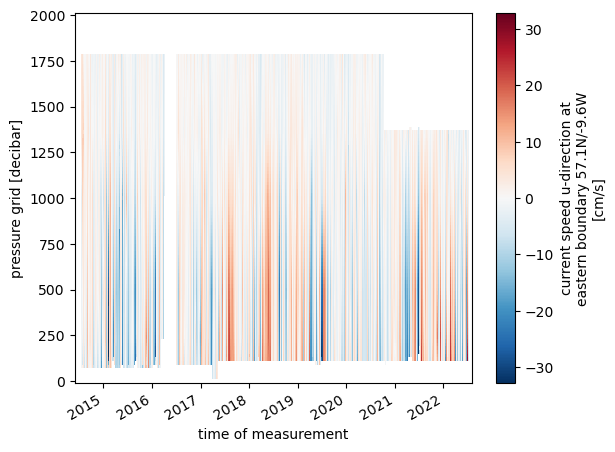

In [14]:
# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.nc'))
ds_RT.U_EAST.plot(x='TIME')
#remove nan at beginning and end
# ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)

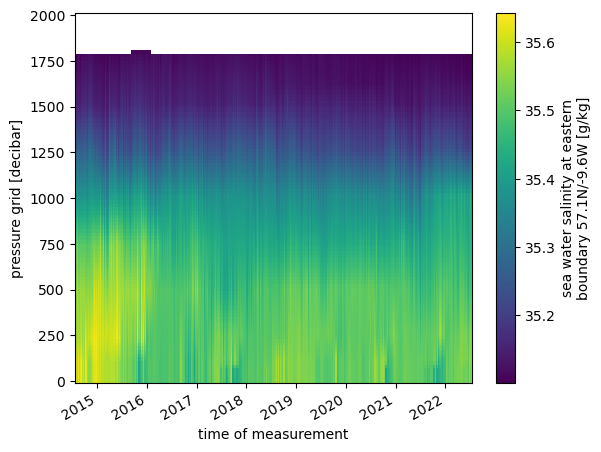

In [69]:
def repeat_upper_values(var):
    mask = var.notnull()
    mask = mask + var.shift(PRES=-10).notnull()
    var = var.interpolate_na(
        dim='PRES',
        method="nearest",
        fill_value="extrapolate",
    ).where(mask)
    return var

var = repeat_upper_values(ds_RT.SG_EAST)
var.plot(x='TIME')


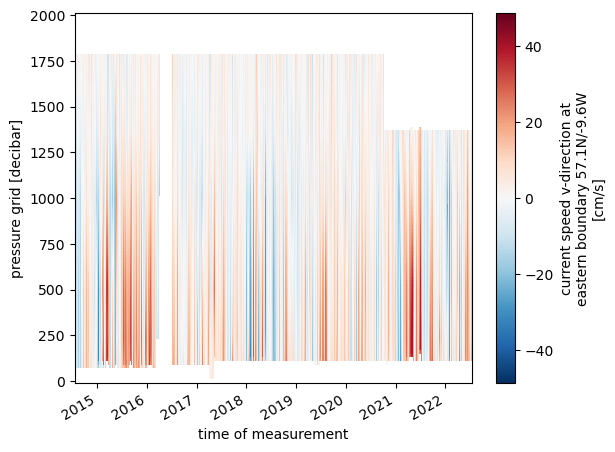

In [86]:
def linear_upper_values(var):
    var = ds_RT.V_EAST
    mask = var.notnull()
    mask = mask + var.shift(PRES=-12).notnull()
    var = var.interpolate_na(
        dim='PRES',
        method="linear",
        fill_value="extrapolate",
    ).where(mask)
    return var

var = linear_upper_values(ds_RT.V_EAST)
ds_RT.V_EAST.plot(x='TIME')

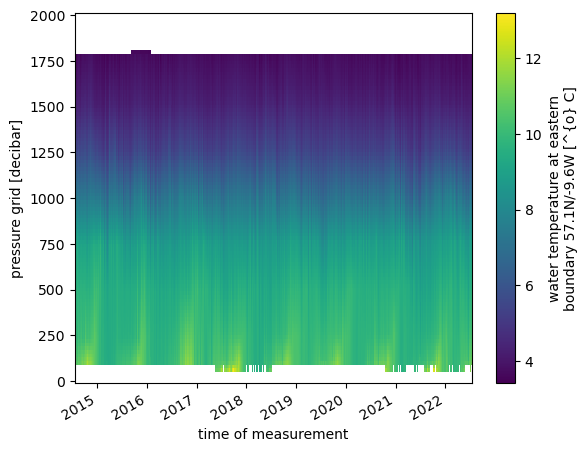

In [21]:
# #linearly interpolate over time gaps in velocity fields
# ds_RT = ds_RT.interpolate_na(dim='TIME')

# # Get z from P
# ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([lat_RTWB, lat_RTEB]))
# ds_RT = rtf.ds_rt_swap_vert_dim(ds_RT)

In [13]:
# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((GEBCO_data_path/GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(GLORYS_fn_an)
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude # lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sa07kb\\OneDrive - SAMS\\data\\data_RT_mooring\\Rockall_Trough_mooring_gridded_TSUV_201407_202207v0.nc'

In [ ]:
#Reconstructed Rockall Trough transport section
ds_q_RT = xr.open_dataset((RT_q_data_path/RT_q_fn))
ds_q_RT['v_EW']=(ds_q_RT.q_EW/(ds_q_RT.dx_EW*ds_q_RT.dz))
ds_q_RT.v_EW.attrs = {'name':'vcur',
                    'long_name':'Meridional Velocities',
                    'units':'m/s'}
ds_q_RT = ds_q_RT.sel(depth=slice(None,1000))

In [ ]:
# glider data
df_glider = mat73.loadmat((glider_data_path/glider_fn))

glider_tgrid =matlab_fct.mt2dt(df_glider['t_grid'])
# df_glider['x2_grid'] # xgrid, m with respect to EB1
# df_glider['z_grid'] # z_grid, depth in m
# df_glider['v_grid'] # meridional velocity, m/s
# lat_grid, lon_grid will give position of idealize sections

ds_glider = xr.Dataset(
    data_vars=dict(
        vcur=(['x','depth','time'],df_glider['v_grid'])),
    coords=dict(
        time=glider_tgrid,
        x=df_glider['x2_grid'],
        depth=df_glider['z_grid'],
        xT=df_glider['x_grid'],
        lat=('xT',df_glider['lat_grid']),
        lon=('xT',df_glider['lon_grid'])),
    attrs=dict(
        description='Meridional velocities derived from repeated glider section following Frase et al. (2022), https://doi.org/10.1029/2022JC019291'))
ds_glider = ds_glider.interp(xT=ds_glider.x).drop_vars('xT')
ds_glider = ds_glider.swap_dims({'x':'lon'})
ds_glider.vcur.attrs = {'name':'vcur',
                        'long_name':'Meridional Velocities',
                        'units':'m/s'}
ds_glider.lat.attrs = {'units':'degN',
                       'long_name':'Latitude'}
ds_glider.lon.attrs = {'units':'degE',
                       'long_name':'Longitude'}
ds_glider.depth.attrs= {'units':'m',
                        'long_name':'Depth'}
ds_glider.x.attrs= {'units':'m',
                        'long_name':'Distance from RTEB1, positive towards east'}

# Analysis

#### To Do
- [ ] Calc some stats for glider reconstruction
- [ ] Calc transport instead of spatially average velocities
- [ ] Add attributes
- [ ] Repeat using EOFs instead of EOFs -> this notebook
- [ ] Repeat using extended EOFs instead of EOFs

#### Acronyms
- Glider - velocity from glider sections May 2020- Feb 2023
- RT EW full - full data set (Jul 2014- Jul 2022) - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- RT EW 2020-2022 - data from period Jan 2020- Jul 2022 - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- RT EW resampled - data interpolated on Glider time stamp (May 20-Jul 23) -velocity section from eastern wedge transport reconstruction (Fraser et al., 2022) 
    !NOTE: RT EW time series ends in July 2022 and does not cover full glider timeseries!

## Mean velocity section

In [ ]:
fig,axs = plt.subplots(1,4,figsize=[15,3])
vmin,vmax,levs=-0.2,0.2,41
ds_q_RT['depth']=-1*ds_q_RT.depth
ax=axs[0]
ds_glider.vcur.mean(['time']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('Glider')
ax=axs[1]
ds_q_RT.v_EW.mean(['TIME']).plot(x='lon_EW',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW full')
ax=axs[2]
ds_q_RT.v_EW.interp(TIME=ds_glider.time.values
                   ).mean(['TIME']).plot(x='lon_EW',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW 2020-2022')
ax=axs[3]
ds_q_RT.v_EW.sel(TIME=slice('2020',None)
                ).mean(['TIME']).plot(x='lon_EW',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW resampled')
plt.tight_layout()

We are missing the undercurrent in ER EW reconstruction.

## Seasonal Cycle - spatially averaged velocity

In [ ]:
color='C0'
m=ds_glider.vcur.groupby('time.month').mean(['time','lon','depth'])
d=ds_glider.vcur.groupby('time.month').std('time').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='Glider')

color='C1'
m = ds_q_RT.v_EW.groupby('TIME.month').mean(['TIME','lon_EW','depth']) 
d=ds_q_RT.v_EW.groupby('TIME.month').std('TIME').mean(['lon_EW','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW full')

color='C2'
m = ds_q_RT.v_EW.interp(TIME=ds_glider.time.values
                ).groupby('TIME.month').mean(['TIME','lon_EW','depth'])
d=ds_q_RT.v_EW.interp(TIME=ds_glider.time.values
                ).groupby('TIME.month').std('TIME').mean(['lon_EW','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW resampled')

color='C3'
m = ds_q_RT.v_EW.sel(TIME=slice('2020',None)
                ).groupby('TIME.month').mean(['TIME','lon_EW','depth'])
d=ds_q_RT.v_EW.sel(TIME=slice('2020',None)
                ).groupby('TIME.month').std('TIME').mean(['lon_EW','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW 2020-2022')
plt.legend()
plt.grid()

When resampled on the same time stamp, the glider and the RT EW reconstruction are quite silimar. However, when compared to the full time series it is clear that the seasonal cycle reconstructed from the glider still suffers from aliasing.

August high velocities in glider section dominated by values observed in August 2022 (see figure below). Unfortunatly the moored transport time series ends in July 2022!

## Time series in original resolution 2020-2022 - spatially averaged velocity

In [ ]:
ds_q_RT.v_EW.sel(TIME=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                ).mean(['lon_EW','depth']).plot.line('-',label='RT EW orig',figsize=[12,3],color='C1')
ds_glider.vcur.mean(['lon','depth']).plot.line('-',label='glider',color='C0')
# ds_q_RT.v_EW.interp(TIME=ds_glider.time.values
#                 ).mean(['lon_EW','depth']).plot.line('-',label='RT EW resampled')
plt.legend()
plt.grid()

# EOF

### Idealized dataset
- Barotropic signal varying only in time with a period of T=365 days + Travelling wave with a  period of T=73 days
- Amplitude of annual signal is 1.5 higher than travelling wave

#### Snapshots of idealiezed dataset for different time periods

In [ ]:
T=73
x = xr.DataArray(np.linspace(0,10,101),dims='x')
y = xr.DataArray(np.linspace(0,5,101),dims='y')
t = xr.DataArray(np.linspace(0,5*365,5*73+1),dims='time')
w=2*np.pi/T
k=2*np.pi/20
l=2*np.pi/10

v = np.sin(k*x+l*y+w*t)+1.5*harmonic_cycle(t, T=365, phi=0)
v = v-v.mean('time')

v.name='v'
v.coords['x']=x
v.coords['y']=y
v.coords['time']=t
v.time.attrs = {'units':'days'}

v.sel(time=[0,20,35,50,75]).plot(x='x',col='time')
plt.show()

#### Results of the EOF analysis of the idealized dataset

In [ ]:
model = EOF_func(v)

This is a demonstration how to interprete the figures below. The EOF scores show the temporal evolution (principle components) of the pattern (components). A moving pattern in a EOF often is presented in two modes (e.g. mode 2 and 3 in example above). Mode 2 and 3 were captured by mode 2 in the HEOF analysis.

In the following I applied the same method to the glider and ET EW velocity sections

### Glider data
Resampled to 15 days and mean removed

In [ ]:
# remove mean
v_anomaly = ds_glider.vcur.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

glider_EOF = EOF_func(v_anomaly,dim='lon')

The EOF components and their explained variance are similar to the components amplitude and expl. var. of the HEOF analysis. This suggests, that the signals are not travelling in space!

The first EOF seems to display a strengthing/weakening of the velocity field in time of same sign in the entire domain explaining 67% of the variance in the glider section. This agrees well with the phase and explained variance of EOF 1 of the reconstructed velocity section using EB1 and GLORYS12v2 output at the ADCP position following Fraser et al. (2022). Here the temporal strengthening/weakening explains up to 83% (see figures below for different time periods). However, comparing the amplitudes between glider and reconstructed velocities the later are dominated by velocities at EB1 while the glider section show highest amplitudes between EB1 and the ADCP.

Undercurrent in glider EOF 1 is visible with low amplitudes and a up to ~90 degree phase shift (dark red to dark blue ~90)

The second EOF I would interprete a zonal shift of the slope current with negative velocity to the west of the slope current when the slope current sits shallow in the east onto the shelf and vice versa. Again, EOF2 from the reconstructed veloctiy field (Fraser et al., 2022) agrees well with the glider results. The zero crossing in the reconstructed velocity fields seems to be too far west compared to glider sections.

Again, undercurrent in glider EOF 2 visible with low amplitudes/high east/west of its core in EOF1. Phase shift of ~180 degree between the high/low amplitudes --> zonally migration? --> see if present in ship ladcp?

EOF 3&4 from the glider sections are quite similar and more difficult to interprete. Together they explain up to 9%. I am wondering whether this depicts the vertical migration of the under current or some kind of recirculation between EB1 and the ADCP position? This feature is not visible in the velocity reconstruction from the moored observation (Fraser et al., 2022) which make sense as we do not have any information what happens between EB1 and the ADCP.

### Rockall EW reconstruction
#### Full timeseries (2014-2022) 
original resolution, mean removed


In [ ]:
v_anomaly = ds_q_RT.v_EW.rename({'TIME':'time'})

# remove mean
# v_anomaly = v_anomaly.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

model = EOF_func(v_anomaly,dim='lon_EW')

#### 2020-2022 
original resolution - mean removed

In [ ]:
v_anomaly = ds_q_RT.v_EW.sel(TIME=slice('2020','2022')).rename({'TIME':'time'})

# remove mean
# v_anomaly = v_anomaly.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

model = EOF_func(v_anomaly,dim='lon_EW')

#### Interp on glider time stamps
15D averaged and mean removed

In [ ]:
v_anomaly = ds_q_RT.v_EW.interp(TIME=ds_glider.time.values).rename({'TIME':'time'})
# remove mean
v_anomaly = v_anomaly.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

model = EOF_func(v_anomaly,dim='lon_EW')

# Reconstruction
Idea: Use the spatial pattern from the EOF ($X$) reproduce velocity section ($y$) for the eastern wedge:
$$
X \alpha = y
$$

Therefore we first need to find alpha. We know y at certain locations: the meridional velocities from RTEB1 and GLORYS2v12-ADCP. We can stack them together to get $y_{loc}$, use the EOF at the mooring positions ($X_{loc}$) and find alpha by solving:

$$
X_{loc}^{T}X_{loc} \alpha = X_{loc}^{T}y_{loc}
$$
$$
\alpha = (X_{loc}^{T}X_{loc})^{-1} X_{loc}^{T}y_{loc}
$$



In [ ]:
def lin_reg(X,y):
    XT = X.transpose() # dims (mode,depth*lon)
    XT_X = np.matmul(XT,X) # dims (mode,mode)
    XT_y = np.matmul(XT,y) # dims (mode,time)
    alpha=np.matmul(np.linalg.inv(XT_X),XT_y) # dims (mode,time)
    # print(f'alpha dims: {alpha.shape}')
    return alpha

def EOF_alpha(ds_X,ds_y):
    # reshape to (depth*lon,time)
    y = np.matrix(ds_y.stack(loc=['depth','lon']).fillna(0).to_numpy()).transpose()
    # print(f'y dims: {y.shape}')

    ds_X['depth']=np.abs(ds_X.depth)
    ds_X = ds_X.reindex(depth=list(reversed(ds_X.depth)))
    ds_X['lat']=glider_locs.lat
    # reshape dimension (depth*lon,mode)
    X = np.matrix(ds_X.stack(loc=['depth','lon']).fillna(0).to_numpy()).transpose()
    # print(f'X dims: {X.shape}')
    
    return xr.DataArray(data=lin_reg(X,y),coords=dict(mode=(ds_X.mode),time=ds_y.time))

def rec_v_sec(ds_X,ds_y):
    v_rec_sec = xr.DataArray()
    for nmod in ds_X.mode.values:
        alpha = EOF_alpha(ds_X.sel(mode=slice(None,nmod)),ds_y)

        # reconstruction = alpha*EOF_EV + mean_glider_section
        v_rec = glider_EOF.components()*alpha+ds_glider.vcur.mean('time')
        v_rec = v_rec.mean('mode')
        v_rec['mode']=nmod
        if nmod == 1:    
            v_rec_sec = v_rec
        else:
            v_rec_sec = xr.concat([v_rec_sec,v_rec],dim='mode')
    return v_rec_sec

In [ ]:
## Recreate glider section using glider obs at point of ERTEB1 and RTADCP for some stats

In [ ]:
# Create y from glider data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[lon_RTEB,lon_RTADCP],method='nearest')
glider_locs['depth']=np.abs(glider_locs.depth)

# Remove glider sections temporal mean from X
ds_y= (glider_locs - glider_locs.mean('time')).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[lon_RTEB,lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec_glider_moor = rec_v_sec(ds_X,ds_y)

In [ ]:
# Create y from glider data for linear regression (X'X*alpha=X'y)
#Use entire glider section for recreation
glider_locs = ds_glider.vcur
glider_locs['depth']=np.abs(glider_locs.depth)

# Remove glider sections temporal mean from X
ds_y= (glider_locs - glider_locs.mean('time')).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().compute()

# get alpha & reconstruct velocity fields
v_rec_glider_full = rec_v_sec(ds_X,ds_y)

In [ ]:
# plot_mean_section(ds_glider,ds_q_RT,v_rec_glider_moor)
# plot_mean_section(ds_glider,ds_q_RT,v_rec_glider_moor,mode_no=[1,2],mean=True)
# plot_mean_section(ds_glider,ds_q_RT,v_rec_glider_full,mode_no=[1,2],mean=True)

## Recreate sections from moorings

In [ ]:
# Create y from moored velocity data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[lon_RTEB,lon_RTADCP],method='nearest').mean('time').compute()
glider_locs['depth']=np.abs(glider_locs.depth)

# Get RTEB1 meridional velocity
v_RTEB1=(ds_RT.V_EAST/1e2).interp(depth=('depth',glider_locs.depth.data)).rename({'TIME':'time'}).drop('PRES')

# Get Glorys data at ADCP station and apply corretions
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=glider_locs.lon.sel(lon=[lon_RTADCP],method='nearest').data,
                    latitude=lat_RTADCP,
                    time=('time',v_RTEB1.time.data),
                    depth=('depth',glider_locs.depth.data)) + corr_model

# Duplicate top GLORYS-ADCP values
mask = v_GLO_RTADCP
mask = (mask.notnull()+mask.shift(depth=-1).notnull())
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
v_GLO_RTADCP = v_GLO_RTADCP.where(mask).rename({'longitude':'lon'})


# combinde both to one matrix (time,depth,lon)
ds_y = xr.concat([v_RTEB1,v_GLO_RTADCP.drop_vars(['latitude','lon'])], dim="lon")
ds_y['lon']=glider_locs.lon.data

# Remove glider sections temporal mean from X
ds_y = (ds_y-glider_locs).compute()

# get EOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_EOF.components().sel(lon=[lon_RTEB,lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec = rec_v_sec(ds_X,ds_y)

## Mean section of glider, RT EW full and EOF-reconstructions
- Glider - velocity from glider sections May 2020- Feb 2023
- RT EW full - full data set (Jul 2014- Jul 2022) - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- EOF [X] full - EOF reconstruction averaging over [X] modes for the full mooring time period (Jul 2014- Jul 2022)
- EOF [X] resampled - data interpolated on Glider time stamp (May 20-Jul 23) using EOF reconstruction averaged over [X] modes 
    !NOTE: mooring time series ends in July 2022 and does not cover full glider timeseries!

In [ ]:
plot_mean_section(ds_glider,ds_q_RT,v_rec)

In [ ]:
plot_mean_section(ds_glider,ds_q_RT,v_rec,mode_no=[1,2],mean=True)

In [ ]:
plot_mean_section(ds_glider,ds_q_RT,v_rec,mode_no=[1,2,3,4],mean=True)

## Seasonal Cycle

In [ ]:
fig,axs = plt.subplots(1,3,figsize=[15,3])
ax=axs[0]
plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=1,mean=False)
ax=axs[1]
plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=[1,2],mean=True)
ax=axs[2]
plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=[1,2,3,4],mean=True)

## Time series in original resolution 2020-2022 - spatially averaged velocity

In [ ]:
fig,axs = plt.subplots(3,1,figsize=[12,9])
ax=axs[0]
plot_longterm(ds_glider.interpolate_na(dim="time", method="linear",max_gap='5D'),ds_q_RT,v_rec,ax=ax,mode_no=1,mean=False)
ax=axs[1]
plot_longterm(ds_glider.interpolate_na(dim="time", method="linear",max_gap='5D'),ds_q_RT,v_rec,ax=ax,mode_no=[1,2],mean=True)
ax=axs[2]
plot_longterm(ds_glider.interpolate_na(dim="time", method="linear",max_gap='5D'),ds_q_RT,v_rec,ax=ax,mode_no=[1,2,3,4],mean=True)

EOF mode 1 seems to best to recontruct velocity fields. No additional values gained for variability. Only better representation of slope current structure.